# Agent에 도구 추가

In [1]:
from dotenv import load_dotenv

# API-KEY 읽어오기
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-nano", model_provider="openai")
# model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

### 도구 정의

In [3]:
# pip install langchain-tavily

In [4]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """a와 b를 곱합니다.
    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a * b

# 웹 검색을 도구
tavily = TavilySearch(max_results=2)
# 도구 리스트
tools = [tavily, multiply]

# 도구 테스트
print(tavily.invoke("LangGraph에서 '노드(node)'란 무엇인가요?"))
print()
# 도구 테스트
print(multiply.invoke({"a": 10, "b": 20}))

{'query': "LangGraph에서 '노드(node)'란 무엇인가요?", 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://blog.naver.com/pjt3591oo/223861729229?viewType=pc', 'title': 'langgraph 소개 및 기본개념 : 네이버 블로그', 'content': '노드는 그래프에서 실제 작업을 수행하는 단위입니다. 각 노드는 특정 로직을 담당합니다. 작업은 LLM 호출, 데이터베이스 조회, 계산, 도구 등을 의미합니다.', 'score': 0.84767824, 'raw_content': None}, {'url': 'https://medium.com/@yoony1007/랭체인-코리아-밋업-2024-q2-테디노트-초보자도-할-수-있는-고급-rag-다중-에이전트와-langgraph-제작-e8bec8adfef4', 'title': '초보자도 할 수 있는 고급 RAG: 다중 에이전트와 LangGraph ...', 'content': 'LangGraph 제안. ✓ 각세부과정을 노드(Node)라고 정의. RAG의 8단계를 노드로 패키징. ✓ 이전 노드 > 다음 노드: 엣지(Edge) 연결. 엣지는 방향성 갖고', 'score': 0.8124067, 'raw_content': None}], 'response_time': 0.91, 'request_id': '7f876801-4ba7-4ecd-a1aa-525d757c4770'}

200


In [5]:
import json

# LLM에 입력 되는 값 확인
for i in range(len(tools)):
    print("**** 도구 이름 ****")
    print(tools[i].name)
    print()
    print("**** 도구 설명 ****")
    print(tools[i].description)
    print()
    print("**** 도구 인자 ****")
    print(json.dumps(tools[i].args_schema.model_json_schema(), indent=2))

**** 도구 이름 ****
tavily_search

**** 도구 설명 ****
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.

**** 도구 인자 ****
{
  "description": "Input for [TavilySearch]",
  "properties": {
    "query": {
      "description": "Search query to look up",
      "title": "Query",
      "type": "string"
    },
    "include_domains": {
      "anyOf": [
        {
          "items": {
            "type": "string"
          },
          "type": "array"
        },
        {
          "type": "null"
        }
      ],
      "default": [],
      "description": "A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests inf

## ReAct Agent를 수동으로 구현

- `create_react_agent`를 사용하지 않고 수동 구현

```
chatbot (LLM 추론) → route_tools (판단) → tools (도구 실행) → chatbot (결과 처리)
                   ↘ END (완료)
```

각 단계를 더 정교하게 제어하고 커스터마이징할 수 있다.

In [6]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 에이전트의 상태 정의 클래스
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 상태 기반 워크플로우 생성
graph_builder = StateGraph(State)

# LLM이 도구 호출 여부 판단
llm_with_tools = model.bind_tools(tools)

# chatbot 노드 함수
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 워크플로우에 chatbot 노드 추가
graph_builder.add_node("chatbot", chatbot)
graph_builder

### 도구 실행 함수 생성

#### ToolMessage
- LangGraph에서 도구(tool) 실행 결과를 표현하기 위한 특별한 메시지 객체.  
- 일반 AIMessage나 HumanMessage처럼 대화의 한 턴을 나타내지만, 특히 “이건 도구 실행의 결과다”라는 것을 그래프 런타임에 알려주는 역할.

In [7]:
import json
from langchain_core.messages import ToolMessage

# 도구 실행 클래스
class BasicToolNode:
    """마지막 AIMessage에서 요청된 도구들을 실행하는 노드"""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: State):
        # 입력 상태에서 메시지 리스트를 추출.
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 이름을 이용해 도구 호출
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 도구 결과를 `ToolMessage` 형식으로 변환하여 출력 리스트에 추가
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # 도구 호출 결과를 포함한 메시지 리스트를 반환
        return {"messages": outputs}

# BasicToolNode 인스턴스 생성
tool_node = BasicToolNode(tools=tools)
# tools 노드를 워크플로우에 추가
graph_builder.add_node("tools", tool_node)

### 조건부 에지(conditional_edge) 추가

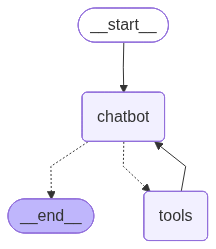

In [8]:
def route_tools(state: State):
    """
    conditional_edge에서 사용하여 마지막 메시지에 도구 호출이 있으면 
    ToolNode로 라우팅하고, 그렇지 않으면 종료로 라우팅합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]  # 마지막 메시지 (LLM 응답)
    else:
        raise ValueError(f"tool_edge로 전달할 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
    
    # LLM 응답에 `tool_calls`가 있으면 `tools` 노드로 이동.
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # 없으면 END 노드로 이동 (종료)
    return END


# 조건부 라우팅: tools로 이동하거나 END로 종료.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 라우팅 결과를 노드 이름으로 매핑
    {"tools": "tools", END: END},
)

# tools 노드 실행 후 chatbot 노드로 다시 이동 (도구 결과 처리)
graph_builder.add_edge("tools", "chatbot")
# 워크플로우 시작점에서 chatbot 노드로 이동
graph_builder.add_edge(START, "chatbot")
# 워크플로우 컴파일, 실행 가능한 워크플로우 생성
graph = graph_builder.compile()
graph

### graph.invoke vs. graph.stream

In [9]:
response = graph.invoke({"messages": [
        {"role": "system", "content": "주어진 도구를 사용하세요."},
        {"role": "user", "content": "2 곱하기 100 은 얼마인가요?"}
    ]})
response

{'messages': [SystemMessage(content='주어진 도구를 사용하세요.', additional_kwargs={}, response_metadata={}, id='9bb5c583-9067-40bd-90e2-9dc9ae2c62d6'),
  HumanMessage(content='2 곱하기 100 은 얼마인가요?', additional_kwargs={}, response_metadata={}, id='6e7dc407-dfa7-49b9-91c5-295076aa9d01'),
  AIMessage(content='200입니다. 2 × 100 = 200. 다른 수학 문제도 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 1413, 'total_tokens': 1509, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMtPYnD1ZQ1fM5YFYK8faalMhFQDi', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7f109b0d-5937-46d2-9172-d91c4290ce89-0', usage_metadata={'input_tokens': 1413, 'output_tokens': 96, 'total_tokens': 1

In [10]:
for message in response['messages']:
    message.pretty_print()

================================ System Message ================================

주어진 도구를 사용하세요.
================================ Human Message =================================

2 곱하기 100 은 얼마인가요?
================================== Ai Message ==================================

200입니다. 2 × 100 = 200. 다른 수학 문제도 도와드릴까요?


--------

## create_react_agent 로 ReAct Agent 구현

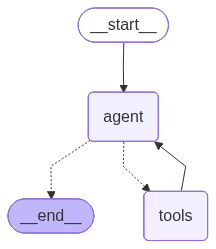

In [17]:
from langgraph.prebuilt import create_react_agent

# ReAct 에이전트 생성
agent = create_react_agent(
    model=model,  
    tools = [tavily, multiply],                    # 에이전트가 사용할 도구 목록
    prompt="당신은 도움이 되는 어시스턴트입니다. 주어진 도구를 이용해 답변하세요."    # 에이전트의 역할과 동작을 정의하는 프롬프트
)
agent

(대화 예시)
```
사용자:  지금 서울의 날씨가 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_LBshVOFPi8aaOY4OMvQsg2xo)
 Call ID: call_LBshVOFPi8aaOY4OMvQsg2xo

 사용자:  100 곱하기 2 는 얼마야?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2E2bRfRICTDKAurlV8S6i7dm)
```

In [18]:
def stream_graph_updates(user_input: str):
    # 워크플로우를 스트리밍 모드로 실행 (사용자 입력 처리)
    events = agent.stream({"messages": [{"role": "user", "content": user_input}]})
    for event in events:
        for value in event.values():
            # 이벤트의 마지막 메시지 출력
            last_msg = value["messages"][-1]
            # ToolMessage는 출력 제외
            # if isinstance(last_msg, ToolMessage):
            #     continue
            last_msg.pretty_print()

while True:
    try:
        user_input = input("사용자: ")  # 사용자 입력 받기
        if user_input.lower() in ["quit", "exit", "q"]:  # 종료 조건
            print("Goodbye!")
            break

        # 워크플로우 실행
        stream_graph_updates(user_input)
    except Exception as e:
        print(e)
        break

사용자:  지금 서울 기온에 10을 곱하면 몇도야?


================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_RdPveFgTGGBLTQptZ4n915Lk)
 Call ID: call_RdPveFgTGGBLTQptZ4n915Lk
  Args:
    query: 서울 현재 기온
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "서울 현재 기온", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.aqi.in/weather/ko/south-korea/seoul/seoul", "title": "Seoul 날씨 상태: 기온 | 30일 예보 - AQI.in", "content": "---\n\nAQI 표준\n\nPreferred Language\n\n---\n\n Weather\n South Korea\n Seoul\n Seoul\n\nAQI\n날씨\n\nSeoul Weather Conditions\n\nCurrent Temperature Level\n\n21  °C\n\nPartly cloudy\n온도 \n습도\n\n38 AQI\n\nPM2.5 : \n7\nPM10 : \n15\n\n공기질 지수는:  좋음\n\n마지막 업데이트: 2025-10-04 11:00 (현지 시간)\n\n## Seoulの天気パラメーター ---\n\n5 km/h\n\nLight breeze\n\n2 m/s\n\n69° ENE\n\n75 %\n\n---\n\n10 km\n\n0.06 mm\n\n1015 mb\n\n940\n956\n\n981\n\n1005\n\n보통\n\n1013\n\n1030

사용자:  quit


Goodbye!


----------------------
우리는 `messages`를 상태로 사용하고, **도구가 바인딩된 채팅 모델**을 사용하는 그래프를 만들었습니다.

이 그래프는 다음과 같은 동작을 할 수 있었습니다:  
* 도구 호출을 반환
* 자연어 응답을 반환

# 라우터 (Router)

1. **도구를 실제로 호출하는 노드**를 추가합니다.
2. **조건부 엣지**를 추가하여, 채팅 모델의 출력을 확인한 뒤

   * 도구 호출이 있다면 도구 노드로
   * 도구 호출이 없다면 바로 종료 노드로 이동하도록 라우팅합니다.

![라우터 예시 이미지](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

In [19]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = model.bind_tools([multiply])

우리는 [내장된 `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)를 사용하며,
**초기화 시 도구 목록(list of tools)** 만 전달하면 됩니다.

또한, [내장된 `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition)를
**조건부 엣지(conditional edge)** 로 사용합니다.

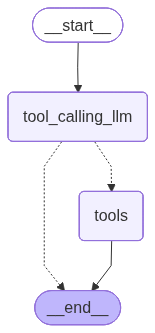

In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # 만약 assistant의 마지막 메시지(결과)가 도구 호출이면 -> tools_condition은 tools 노드로 이동합니다.
    # 만약 assistant의 마지막 메시지가 도구 호출이 아니면 -> tools_condition은 END 노드로 이동합니다.
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()
graph

In [21]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(content="주어지 도구를 사용해서 답하세요."),
    HumanMessage(content="안녕, 2 곱하기 2는 얼마야?")
]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

주어지 도구를 사용해서 답하세요.
================================ Human Message =================================

안녕, 2 곱하기 2는 얼마야?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_FWYbCrVu160Czg9bCD5BUBl0)
 Call ID: call_FWYbCrVu160Czg9bCD5BUBl0
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
